# Lab 8: Real-world data
Our goal today is to practice data interpretation and plotting with messy, real-world data.  

Our science question is: how does ocean temperature in the Pacific vary during ENSO events?

Below is only helper code.  You will receive a paper handout with some contour plots to process and questions to analyse.  You should set up your own Jupyter notebook and work through at your own pace.

In [18]:
#!pip install matplotlib
import matplotlib.pyplot as plt
#!pip install numpy
import numpy as np
#!pip install xarray
import xarray as xr

---
## Helper code: filling missing values

Below I show how to deal with a dataset with multiple data gaps.  There are many ways to deal with this in various Python packages; I am demonstrating some simple built-in functions in xarray called `interp` and `interpolate_na`.

Let's load in the data and inspect it.

In [19]:
ds = xr.open_dataset('t_xyzt_mon_199901.cdf')

In [20]:
ds

<xarray.Dataset> Size: 3kB
Dimensions:  (lon: 10, lat: 1, depth: 25, time: 1)
Coordinates:
  * lon      (lon) float32 40B 147.0 156.0 165.0 180.0 ... 235.0 250.0 265.0
  * lat      (lat) float32 4B 0.0
  * depth    (depth) float32 100B 1.0 5.0 10.0 20.0 ... 250.0 300.0 400.0 500.0
  * time     (time) datetime64[ns] 8B 1999-01-16T12:00:00
Data variables:
    T_20     (lon, lat, depth, time) float32 1kB ...
    QT_5020  (lon, lat, depth, time) float32 1kB ...
    ST_6020  (lon, lat, depth, time) float32 1kB ...
Attributes:
    array:                        TAO/TRITON
    Data_Source:                  GTMBA Project Office/NOAA/PMEL
    Data_info:                    Contact Paul Freitag: 206-526-6727
    File_info:                    Contact Dai McClurg: Dai.C.McClurg@noaa.gov
    Request_for_acknowledgement:  If you use these data in publications or pr...
    missing_value:                1e+35
    _FillValue:                   1e+35

In [21]:
ds.T_20

<xarray.DataArray 'T_20' (lon: 10, lat: 1, depth: 25, time: 1)> Size: 1kB
[250 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 40B 147.0 156.0 165.0 180.0 ... 235.0 250.0 265.0
  * lat      (lat) float32 4B 0.0
  * depth    (depth) float32 100B 1.0 5.0 10.0 20.0 ... 250.0 300.0 400.0 500.0
  * time     (time) datetime64[ns] 8B 1999-01-16T12:00:00
Attributes:
    name:            T
    long_name:       TEMPERATURE (C)long_namet
    generic_name:    temp
    FORTRAN_format:  f10.2
    units:           C
    epic_code:       20

Our variable of interest, `T_20`, has several dimensions of length 1.  For example, it has a `lat` dimension which is always equal to 0 because it's averaged around the equator, and it has a `time` dimension that has only one value, because we downloaded a time slice.  We use `.squeeze()` to remove those dimensions and make this data easier to deal with.

In [22]:
t20 = ds.T_20.squeeze()

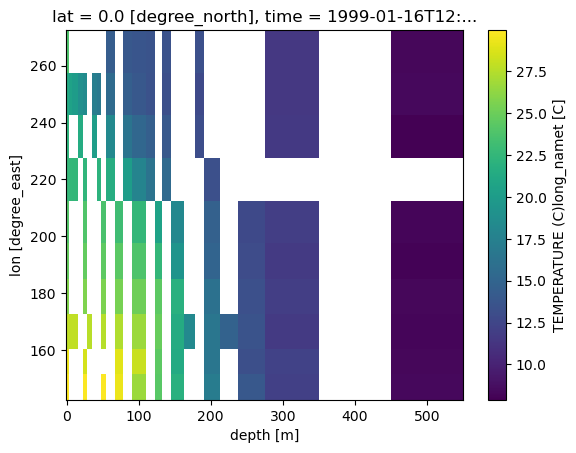

In [24]:
fig, ax = plt.subplots()
t20.plot(ax=ax)

This plot has longitude on the y-axis and temperature on the x-axis.  We can swap these by using `ax.plot(xdata, ydata)` as you've done before, or we can take the [*transpose*](https://en.wikipedia.org/wiki/Transpose) to swap the axes.  The command `.T` takes the transpose.  It works for xarray variables, Numpy arrays, etc.

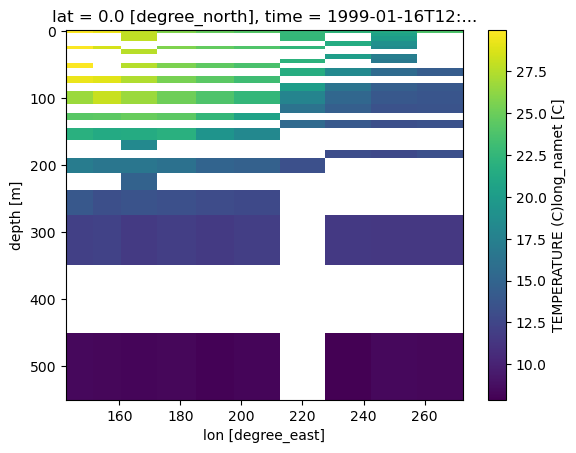

In [25]:
fig, ax = plt.subplots()
t20.T.plot(ax=ax) ## flip the x- and y-axes, for depth on y-axis
ax.invert_yaxis() ## flipping so y-axis increases downward, appropriate for ocean depth section

We can see that there are a lot of data gaps.  The same is true if we try a filled contour plot like we made last week:

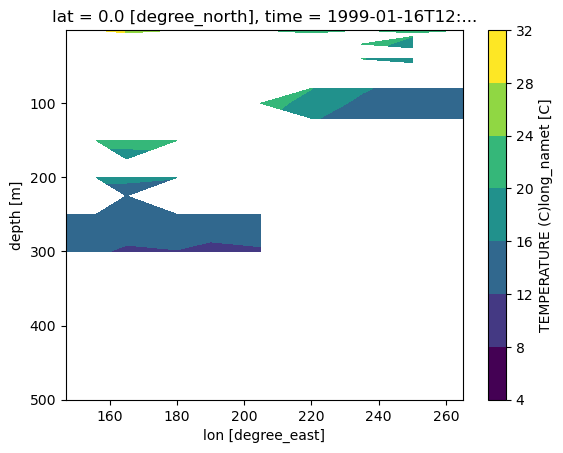

In [26]:
fig, ax = plt.subplots()
t20.T.plot.contourf(ax=ax)
ax.invert_yaxis()

Let's try a temperature profile.

[Text(0.5, 0, 'Temperature [deg. C]'), Text(0, 0.5, 'Depth [m]')]

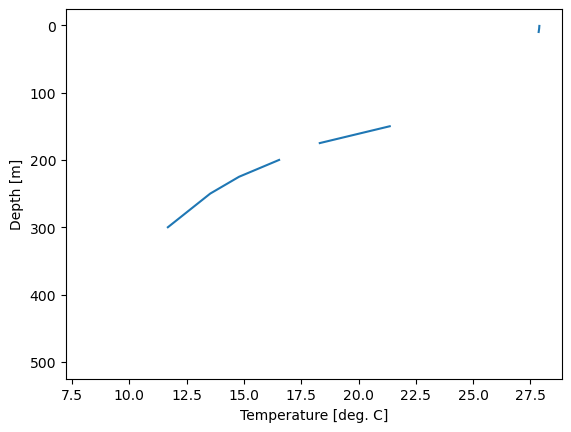

In [27]:
fig, ax = plt.subplots()
# t20.sel(lon=165.0).T.plot(ax=ax) ## .T doesn't work here, for reasons I do not know
ax.plot(t20.sel(lon=165.0), t20.depth.values) ## use good ol' ax.plot instead
ax.invert_yaxis() ## flipping so y-axis increases downward, appropriate for ocean depth section
ax.set(xlabel = 'Temperature [deg. C]', ylabel='Depth [m]')

Also a lot of gaps!  We need to fill these gaps to make profiles comparable to those we were making by hand from TAO/TRITON contour plots.  

Here I am first going to fill `NaN` ("not a number") values in the `t20` variable using `interpolate_na`.  Then, I am going to interpolate with `interp` to find the values along a regularly spaced grid of depth and longitude.

In [28]:
t20_filled = t20.interpolate_na(dim='depth') ## filling NaNs
    
t20_gridded = t20_filled.interp(depth=t20.depth.values, lon=t20.lon.values) ## interpolating the filled data

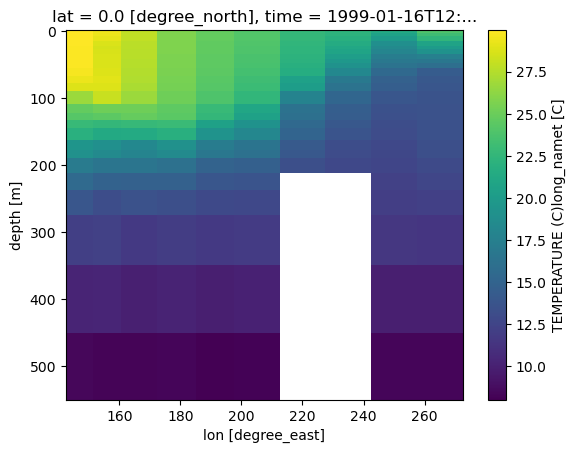

In [29]:
fig, ax = plt.subplots()
t20_gridded.T.plot(ax=ax)
ax.invert_yaxis()

The grid is much more complete now.  Notice that it still ignored a large area of missing data, which is probably for the best.  We don't want a false sense of certainty in an area where we actually don't have any observations.

[Text(0.5, 0, 'Temperature [deg. C]'), Text(0, 0.5, 'Depth [m]')]

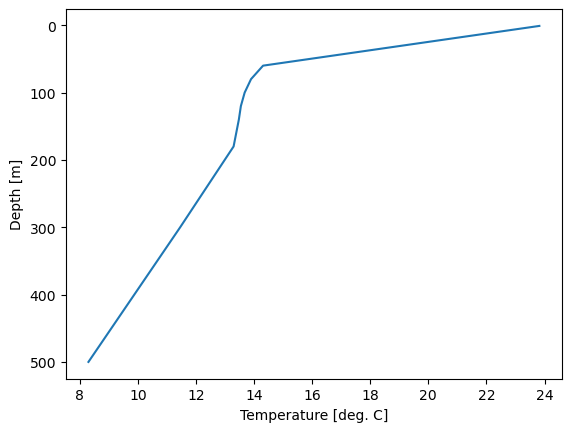

In [31]:
fig, ax = plt.subplots()
ax.plot(t20_gridded.sel(lon=265), t20_gridded.depth.values) ## plotting from t20_gridded instead of t20
ax.invert_yaxis()
ax.set(xlabel = 'Temperature [deg. C]', ylabel='Depth [m]')

Temperature profile is also continuous now, and we can make a much nicer filled contour plot.

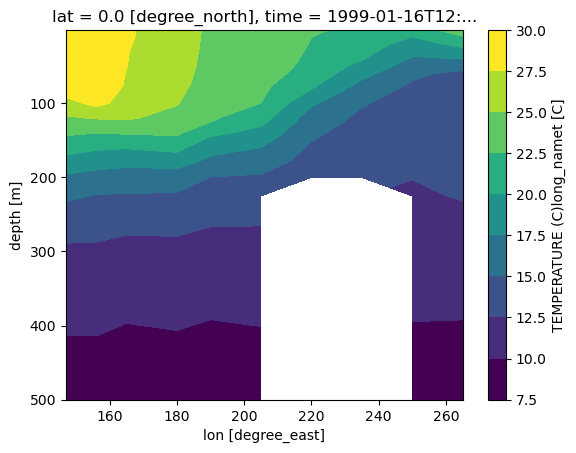

In [32]:
fig, ax = plt.subplots()
t20_gridded.T.plot.contourf(ax=ax, levels=10) ## remember you can modify levels, colorbars, etc.
ax.invert_yaxis()

In [33]:
## it's possible to fill in the lon dimension as well, but could be questionable
t20_filled_lon = t20_filled.interpolate_na(dim='lon')
    
t20_gridded_full = t20_filled_lon.interp(depth=t20.depth.values, lon=t20.lon.values)

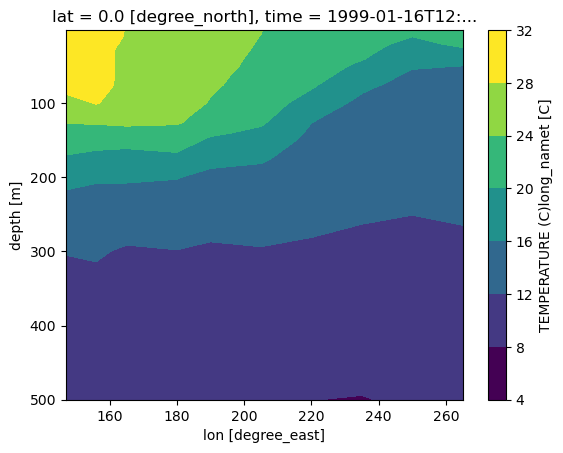

In [34]:
fig, ax = plt.subplots()
t20_gridded_full.T.plot.contourf(ax=ax)
ax.invert_yaxis()

---
## Multiple-panel plots
Finally, to help you compare profiles, I show how to make side-by-side plots with `subplots`.

We've been using `plt.subplots()` to give us access to axes we cou;d control for better plotting.  The same setup actually allows us to make multi-panel figures with ease.  The primary format is:
```
fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True)
axs[which_row,which_column].plot(xdata, ydata)
```
where nrows is the number of rows of panels, ncols is the number of columns, and sharex/sharey define whether the panels should have the same axes limits and scales.  `axs` is now an array of axes rather than the single named `ax` we have used before.  We can access it by naming the axes themselves, or by indexing `axs[which_row,which_column]` as shown above.

Let's apply this to two panels of profiles from our data:

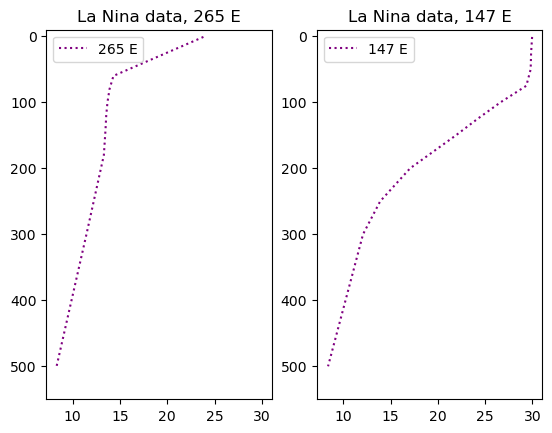

In [36]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(t20_gridded.sel(lon=265), t20_gridded.depth.values, color='purple', ls=':', label='265 E')
ax1.legend(loc='best')
ax1.set(ylim=(550, -10), title='La Nina data, 265 E')

ax2.plot(t20_gridded.sel(lon=147), t20_gridded.depth.values, color='purple', ls=':', label='147 E')
ax2.legend(loc='best')
ax2.set(ylim=(550, -10), title='La Nina data, 147 E');

## Endnotes
- The [xarray user guide on interpolation](https://docs.xarray.dev/en/latest/user-guide/interpolation.html) describes `interp` and `interpolate_na`...plus several other options for various use cases.
- Scipy is also commonly used for interpolation.  Their general landing page is [here](https://docs.scipy.org/doc/scipy/reference/interpolate.html).  I would probably choose `griddata` for an application like this -- documented [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata).
- This notebook last edited by Cam de Wet, 9 Apr 2025